In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

warnings.filterwarnings('ignore')

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training', 
    shuffle=True
)


val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle=False
)


test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f" Training images: {train_gen.samples}")
print(f" Validation images: {val_gen.samples}")
print(f" Testing images: {test_gen.samples}")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
 Training images: 4173
 Validation images: 1043
 Testing images: 624


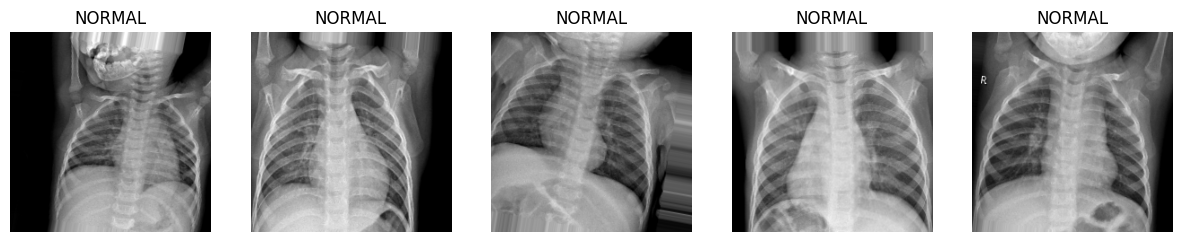

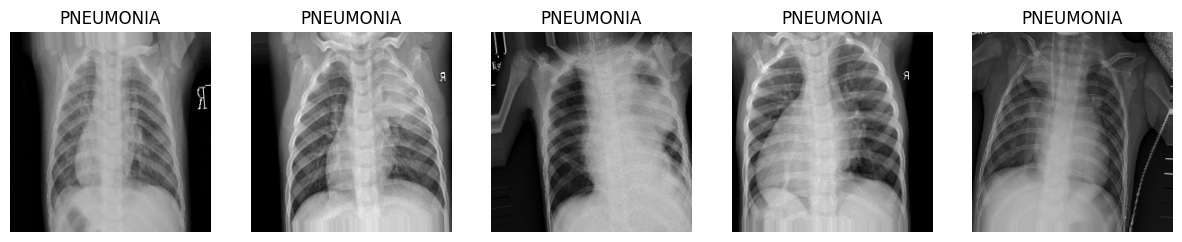

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(generator, class_name, num_samples=5):
    class_index = generator.class_indices[class_name]
    images = []
    labels = []

    for _ in range(len(generator)):
        X, y = next(generator)
        for img, label in zip(X, y):
            if int(label) == class_index:
                images.append(img)
                labels.append(label)
            if len(images) >= num_samples:
                break
        if len(images) >= num_samples:
            break

    plt.figure(figsize=(15,3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(class_name)
    plt.show()

plot_samples(train_gen, 'NORMAL', 5)
plot_samples(train_gen, 'PNEUMONIA', 5)


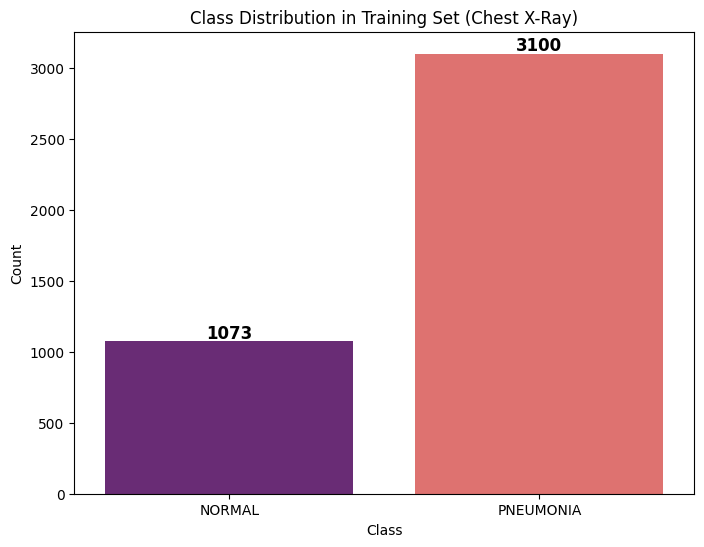

In [13]:

labels = train_gen.classes
class_names = list(train_gen.class_indices.keys())
counts = [np.sum(labels == i) for i in range(len(class_names))]


df_plot = pd.DataFrame({'Class': class_names, 'Count': counts})


plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=df_plot, palette='magma')


for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=12, fontweight='bold')

plt.title('Class Distribution in Training Set (Chest X-Ray)')
plt.show()

In [14]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weight_dict = {i: weights[i] for i in range(len(weights))}

print("Computed Class Weights:")
for i, name in enumerate(class_names):
    print(f"   - {name}: {class_weight_dict[i]:.4f}")


Computed Class Weights:
   - NORMAL: 1.9445
   - PNEUMONIA: 0.6731


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Load ResNet50 as base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # binary classification

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
    ModelCheckpoint('medical_pneumonia_model.keras', save_best_only=True)
]


In [20]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 765ms/step - accuracy: 0.8211 - loss: 0.3713 - precision_5: 0.9509 - recall_5: 0.8017 - val_accuracy: 0.8303 - val_loss: 0.5763 - val_precision_5: 0.8201 - val_recall_5: 0.9884 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 677ms/step - accuracy: 0.8766 - loss: 0.2995 - precision_5: 0.9587 - recall_5: 0.8693 - val_accuracy: 0.5801 - val_loss: 0.6445 - val_precision_5: 1.0000 - val_recall_5: 0.4348 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 685ms/step - accuracy: 0.8831 - loss: 0.2584 - precision_5: 0.9712 - recall_5: 0.8685 - val_accuracy: 0.9358 - val_loss: 0.3256 - val_precision_5: 0.9538 - val_recall_5: 0.9600 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 94s 715ms/step - accuracy: 0.8911 - loss: 0.2420 - precision_5: 0.9679 - recall_5: 0.8842 - val_accuracy: 0.8773 - val_loss: 0.2929 - val_precision_5: 0.9909 - val_recall_5: 0.8426 - learning_rate: 0.0010
Epoch 5/10
131/131 

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 612ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.79      0.84       234
   PNEUMONIA       0.88      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



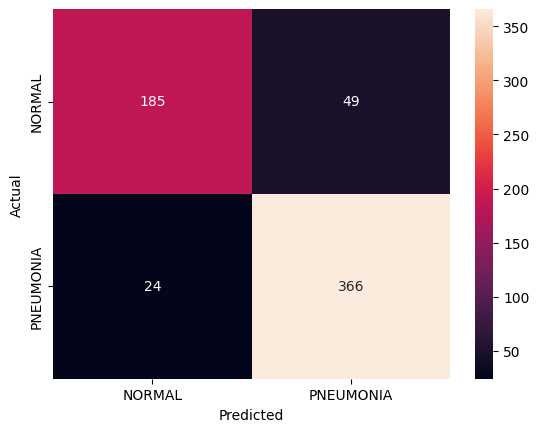

In [22]:
preds = model.predict(test_generator)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(true_labels, pred_labels, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [23]:
model.save('medical_pneumonia_model_final1.keras')

In [24]:
from IPython.display import FileLink
FileLink(r'medical_pneumonia_model_final1.keras')

/kaggle/working/medical_pneumonia_model_final1.keras